## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.stats import norm
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Import our visualization functions
from plotting_utils import (
    plot_gp_1d, plot_acquisition_1d, plot_bo_iteration_1d,
    plot_2d_function, plot_2d_bo_state, plot_convergence,
    plot_parallel_coordinates
)

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


Setup

In [5]:
f1_Inputs = np.load('initial_data/function_1/initial_inputs.npy')
f1_Outputs = np.load('initial_data/function_1/initial_outputs.npy')

f2_Inputs = np.load('initial_data/function_2/initial_inputs.npy')
f2_Outputs = np.load('initial_data/function_2/initial_outputs.npy')



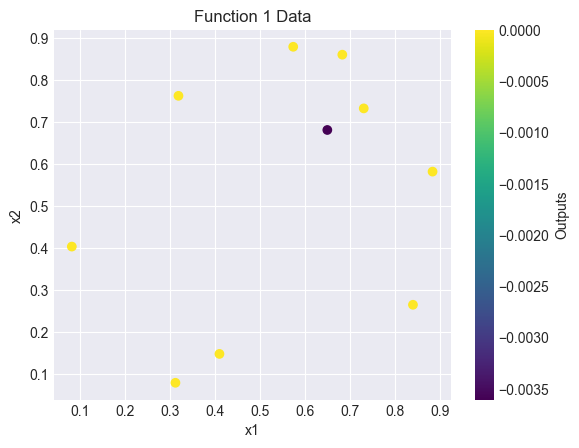

In [6]:
x1, x2 = np.split(f1_Inputs, [1], axis=1) 
plt.scatter(x1, x2, c=f1_Outputs, cmap="viridis")
plt.colorbar(label="Outputs")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Function 1 Data")
plt.show()

In [ ]:
x1, x2 = np.split(f2_Inputs, [1], axis=1) 
plt.scatter(x1, x2, c=f2_Outputs, cmap="viridis")
plt.colorbar(label="Outputs")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Function 2 Data")
plt.show()

In [ ]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    
    UCB = mean + kappa * std
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation
    kappa : exploration parameter (higher = more exploration)
    """
    return mu + kappa * sigma


def expected_improvement(mu, sigma, y_best, xi=0.01):
    """
    Expected Improvement (EI) acquisition function.
    
    EI = E[max(f(x) - f(x_best), 0)]
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation  
    y_best : best observed value so far
    xi : exploration parameter
    """
    with np.errstate(divide='warn'):
        improvement = mu - y_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei


In [ ]:
def bayesian_optimization_2d(bounds):
  
    n_dims = len(bounds)
    best_values = [f1_Outputs.max()]
  
    # Fit GP
    kernel = ConstantKernel(1.0) * RBF(length_scale=0.3)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6,
                                 n_restarts_optimizer=10)
    gp.fit(f1_Inputs, f1_Outputs)
    
    # Define acquisition function for optimization
    def acq_objective(X):
        X = X.reshape(1, -1)
        mu, sigma = gp.predict(X, return_std=True)
        
        acq_val = upper_confidence_bound(mu, sigma, kappa=4.0)
        return -acq_val  # Negative because we use the 'minimize' function later
    
    # Optimize acquisition function (multi-start)
    best_acq = np.inf
    X_next = None
    
    for _ in range(50):  # Multiple random starts
        x0 = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
        result = minimize(
            acq_objective, x0, 
            bounds=bounds, 
            method='L-BFGS-B'
        )
        print('Considering ', x0, ' result is ', result.fun)
        if result.fun < best_acq:
            best_acq = result.fun
            X_next = result.x
    
    return X_next


# Run 2D optimization
nextInput = bayesian_optimization_2d(bounds=[(0, 1), (0, 1)])
print (nextInput)



In [ ]:
def bayesian_optimization_nd(n_dims, X_samples, y_samples, acquisition='ei'):
    """
    Bayesian Optimization for n-dimensional functions.
    Assumes bounds [0, 1] for all dimensions.
    """
    bounds = [(0, 1) for _ in range(n_dims)]
    
    # Use provided data
    best_values = [y_samples.max()]
    
    print(f"Starting {n_dims}D optimization with {len(X_samples)} initial samples...")
    print(f"Initial best output: {y_samples.max():.8f}\n")
    
    # Fit GP
    kernel = ConstantKernel(1.0) * RBF(length_scale=0.3)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6,
                                 n_restarts_optimizer=5)
    gp.fit(X_samples, y_samples)
    
    # Optimize acquisition function
    def acq_objective(X):
        X = X.reshape(1, -1)
        mu, sigma = gp.predict(X, return_std=True)
        
        if acquisition == 'ei':
            acq_val = expected_improvement(mu, sigma, y_samples.max())
        else:
            acq_val = upper_confidence_bound(mu, sigma, kappa=6.0)
        
        return -acq_val
    
    # Multi-start optimization
    best_acq = np.inf
    X_next = None

    #'Grid search of values?
    for _ in range(10**n_dims-2):  # More starts for higher dimensions
        x0 = np.random.uniform(0, 1, n_dims)
        result = minimize(acq_objective, x0, bounds=bounds, method='L-BFGS-B')
        #print('Considering ', x0, ' result is ', result.fun)
        if result.fun < best_acq:
            best_acq = result.fun
            X_next = x0
    
    #Return next point to submit
    return X_next, best_acq


def findNextGuess(functionName, f_inputs, f_outputs): 
    
    f_maxInput = np.max(f_inputs, axis=0) #Output per dimension
    f_minInput = np.min(f_inputs, axis=0)
    f_maxOutput = np.max(f_outputs)
    f_minOutput = np.min(f_outputs)
    numDimensions = len(f_maxInput)

    print('********************')
    print(functionName, ' - ', numDimensions, 'D')
    print('********************')
    print(' Input -   Min:',  f_minInput, ', Max: ', f_maxInput )
    print(' Output -  Min:',  f_minOutput, ', Max: ', f_maxOutput )
    print(' First two input rows: ')
    print(f_inputs[:2])
    print(' First two output rows:')
    print(f_outputs[0:1])
    print(f_outputs[1:2])
    
    nextInput, acqFunctionValue = bayesian_optimization_nd(n_dims = numDimensions, X_samples = f_inputs, y_samples = f_outputs, acquisition='UCB')
    roundedNextInput = np.round(nextInput, 6)
    print()
    print('Try: ', roundedNextInput)
    print()


In [ ]:
f1_Inputs = np.load('initial_data/function_1/initial_inputs.npy')
f1_Outputs = np.load('initial_data/function_1/initial_outputs.npy')
findNextGuess('F1', f1_Inputs, f1_Outputs)

In [ ]:
f2_Inputs = np.load('initial_data/function_2/initial_inputs.npy')
f2_Outputs = np.load('initial_data/function_2/initial_outputs.npy')



#findNextGuess('F2', f2_Inputs, f2_Outputs)

In [ ]:
f3_Inputs = np.load('initial_data/function_3/initial_inputs.npy')
f3_Outputs = np.load('initial_data/function_3/initial_outputs.npy')
#findNextGuess('F3', f3_Inputs, f3_Outputs)

In [ ]:
f4_Inputs = np.load('initial_data/function_4/initial_inputs.npy')
f4_Outputs = np.load('initial_data/function_4/initial_outputs.npy')
#findNextGuess('F4', f4_Inputs, f4_Outputs)

In [ ]:
f5_Inputs = np.load('initial_data/function_5/initial_inputs.npy')
f5_Outputs = np.load('initial_data/function_5/initial_outputs.npy')
#findNextGuess('F5', f5_Inputs, f5_Outputs)

In [ ]:
f6_Inputs = np.load('initial_data/function_6/initial_inputs.npy')
f6_Outputs = np.load('initial_data/function_6/initial_outputs.npy')
#findNextGuess('F6', f6_Inputs, f6_Outputs)

In [ ]:
f7_Inputs = np.load('initial_data/function_7/initial_inputs.npy')
f7_Outputs = np.load('initial_data/function_7/initial_outputs.npy')
#findNextGuess('F7', f7_Inputs, f7_Outputs)

In [ ]:
f8_Inputs = np.load('initial_data/function_8/initial_inputs.npy')
f8_Outputs = np.load('initial_data/function_8/initial_outputs.npy')
#findNextGuess('F8', f8_Inputs, f8_Outputs)